In [1]:
import torch

In [4]:
inputs = torch.tensor([
    [0.43, 0.15, 0.89],
    [0.55, 0.87, 0.66],
    [0.57, 0.85, 0.64],
    [0.22, 0.58, 0.33],
    [0.77, 0.25, 0.10],
    [0.05, 0.80, 0.55]
    ]
)

Text(0.5, 0.92, '3D Plot of word embeddings')

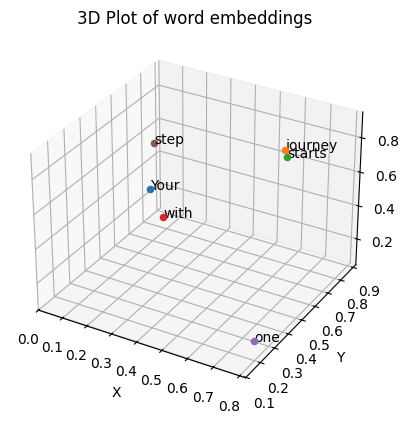

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

input_str = "Your journey starts with one step"
words = input_str.split()

x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x,y,z, word, fontsize=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of word embeddings')

## SELF-ATTENTION BLOCK

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, d_in, d_out, context_size = 4096, dropout=0.0, bias=False):
        super().__init__()

        self.Wq = nn.Linear(d_in, d_out, bias=bias)
        self.Wk = nn.Linear(d_in, d_out, bias=bias)
        self.Wv = nn.Linear(d_in, d_out, bias=bias)
        
        self.dropout = nn.Dropout(dropout)

        self.dk = d_out
        self.register_buffer("mask", torch.triu(torch.ones(context_size, context_size), diagonal=1))

    def forward(self, X):

        batch_size, token_size, embedding_dim = X.shape
        Q = self.Wq(X)
        K = self.Wk(X)
        V = self.Wv(X)

        raw_attention_scores = Q @ K.transpose(-2, -1) / math.sqrt(self.dk)
        masked_attention_scores = torch.masked_fill(
            raw_attention_scores, self.mask.bool()[:token_size, :token_size], -math.inf
        )
        causal_attention = self.dropout(F.softmax(masked_attention_scores, dim=-1))
        context_vectors = causal_attention @ V

        return context_vectors
    
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, n_heads, d_in, d_out, context_size=4096, dropout=0.0, bias=False):
        super().__init__()

        self.heads = nn.ModuleList([SelfAttentionBlock(d_in, d_out, context_size, dropout, bias) for _ in range(n_heads)])

    def forward(self, X):
        return torch.cat([head(X) for head in self.heads])

inputs = torch.tensor([
    [0.43, 0.15, 0.89],
    [0.55, 0.87, 0.66],
    [0.57, 0.85, 0.64],
    [0.22, 0.58, 0.33],
    [0.77, 0.25, 0.10],
    [0.05, 0.80, 0.55]
    ]
)

batched_input = torch.stack((inputs, inputs, inputs), dim=0)
batchsize, token_size, embedding_dim = batched_input.shape

n_heads = 1
d_k = 3
attention = MultiHeadAttentionWrapper(n_heads, embedding_dim, d_k)
attention(batched_input)

tensor([[[ 0.3129,  0.0114, -0.6143],
         [ 0.2117, -0.1797, -0.4103],
         [ 0.1743, -0.2383, -0.3450],
         [ 0.1446, -0.2476, -0.2633],
         [ 0.0870, -0.1973, -0.2665],
         [ 0.1018, -0.2384, -0.2130]],

        [[ 0.3129,  0.0114, -0.6143],
         [ 0.2117, -0.1797, -0.4103],
         [ 0.1743, -0.2383, -0.3450],
         [ 0.1446, -0.2476, -0.2633],
         [ 0.0870, -0.1973, -0.2665],
         [ 0.1018, -0.2384, -0.2130]],

        [[ 0.3129,  0.0114, -0.6143],
         [ 0.2117, -0.1797, -0.4103],
         [ 0.1743, -0.2383, -0.3450],
         [ 0.1446, -0.2476, -0.2633],
         [ 0.0870, -0.1973, -0.2665],
         [ 0.1018, -0.2384, -0.2130]]], grad_fn=<CatBackward0>)

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, n_heads, context_length=1024, dropout=0.0, bias=False):
        super().__init__()

        assert (d_out % n_heads) == 0, "d_out should be a multiple of n_heads"


        self.dk = d_out
        self.n_heads = n_heads
        self.head_dim = d_out // n_heads

        self.Wq = nn.Linear(d_in, d_out, bias=bias)
        self.Wk = nn.Linear(d_in, d_out, bias=bias)
        self.Wv = nn.Linear(d_in, d_out, bias=bias)

        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(d_out, d_out, bias=bias)

        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, X):
        batch_size, token_size, embedding_dim = X.shape

        Q = self.Wq(X)
        K = self.Wk(X)
        V = self.Wv(X)

        Q = Q.view(batch_size, token_size, self.n_heads, self.head_dim)
        K = K.view(batch_size, token_size, self.n_heads, self.head_dim)
        V = V.view(batch_size, token_size, self.n_heads, self.head_dim)

        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        raw_attention_scores = Q @ K.transpose(2, 3) / math.sqrt(K.shape[-1])
        masked_attention_scores = torch.masked_fill(
            raw_attention_scores, self.mask.bool()[:token_size, :token_size], -math.inf
        )
        attention_scores = self.dropout(F.softmax(masked_attention_scores, dim=-1))
        context_vectors = attention_scores @ V
        context_vectors = context_vectors.transpose(1, 2)
        context_vectors = context_vectors.contiguous().view(batch_size, token_size, self.dk)
        context_vectors = self.output(context_vectors)
        return context_vectors


inputs = torch.tensor([
    [0.43, 0.15, 0.89],
    [0.55, 0.87, 0.66],
    [0.57, 0.85, 0.64],
    [0.22, 0.58, 0.33],
    [0.77, 0.25, 0.10],
    [0.05, 0.80, 0.55]
    ]
)

batched_input = torch.stack((inputs, inputs, inputs), dim=0)
batchsize, token_size, embedding_dim = batched_input.shape

n_heads = 96
d_k = 768
attention = MultiHeadAttention(embedding_dim, d_k, n_heads, dropout=0.1)
context_vectors = attention(batched_input)
print(context_vectors.shape) # batch_size, num_tokens, d_k
context_vectors


torch.Size([3, 6, 768])


tensor([[[ 0.0695, -0.0967, -0.4068,  ...,  0.3995,  0.0874,  0.0013],
         [ 0.2563, -0.1224, -0.4424,  ...,  0.4510,  0.0522,  0.0332],
         [ 0.3471, -0.0254, -0.3739,  ...,  0.5190,  0.0574, -0.0343],
         [ 0.3318, -0.0604, -0.2863,  ...,  0.4355, -0.0019, -0.0241],
         [ 0.2922, -0.0708, -0.2815,  ...,  0.4158,  0.0060,  0.0089],
         [ 0.2843, -0.0099, -0.2555,  ...,  0.4174,  0.0143,  0.0226]],

        [[ 0.0893, -0.1497, -0.3485,  ...,  0.5060, -0.0779, -0.1059],
         [ 0.3679, -0.1209, -0.3687,  ...,  0.4958, -0.0318, -0.0354],
         [ 0.2785, -0.0209, -0.4003,  ...,  0.4972,  0.0477, -0.0086],
         [ 0.3490, -0.0927, -0.3243,  ...,  0.4214, -0.0048,  0.0159],
         [ 0.2696, -0.0882, -0.2732,  ...,  0.3960, -0.0074,  0.0190],
         [ 0.2845, -0.0671, -0.2377,  ...,  0.4376, -0.0131,  0.0127]],

        [[ 0.0906, -0.1362, -0.4021,  ...,  0.4209,  0.1005, -0.0853],
         [ 0.2903, -0.0919, -0.3802,  ...,  0.3701,  0.0895,  0.0178],
  

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])